In [7]:
%matplotlib inline
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from scrape.graph import get_merged_summaries_with_final_actual_intensities, create_graph_images, generate_boxplot_ci, generate_boxplot_ci_error, generate_boxplot_ci_error_for_days, generate_plot_ci_lines, generate_boxplot_ci_error_per_hour
from scrape.graph import generate_combined_stats_dataframe, generate_plots_ci_lines_with_boxplots
from scrape.graph import get_dates, save_figure

# Carbon intensity forecast tracking

How this repo operates, for national data:

1. Periodically scrape JSON data from the National Grid API
2. Convert to CSV
3. Summarise in a giant combined CSV
4. Plot graphs and calculate statistics.

Most operations are possible via the CLI: see the `python3 run.py ...` commands.


## 1. Scrape JSON data from the National Grid API

We'll use the existing repo folder `./data`. Subfolders will be created for each endpoint.

The supported endpoints are defined in `api.py`. For national data, we'll use the two endpoints `national_fw48h`, `national_pt24h`.

Run the following commands repeatedly every half-hour until you have gathered the data you want:
```
python run.py download --output_directory data --now --endpoint national_fw48h
python run.py download --output_directory data --now --endpoint national_pt24h
```

Gathering data as it is published, every half hour, is important because historical forecasts are overwritten/unavailable (hence this project).


## 2. Convert to CSV

```
python3 run.py wrangle --input_directory "data/national_fw48h" --endpoint "national_fw48h"
python3 run.py wrangle --input_directory "data/national_pt24h" --endpoint "national_pt24h"
```

This will create `.csv` files in the same directory with identical names as the `.json` files.


## 3. Summarise

```
python3 run.py summary --input_directory "data/national_fw48h" --output_directory "data" --endpoint "national_fw48h"
python3 run.py summary --input_directory "data/national_pt24h" --output_directory "data" --endpoint "national_pt24h"
```
This will create `summary_national_fw48h.csv` and `summary_national_pt24h.csv` files in the `data` directory which combine all the available CSVs into one file.

In [8]:
# Example
df = pd.read_csv("./data/summary_national_fw48h.csv").head()
df

,Unnamed: 0,intensity.forecast,intensity.forecast.1,intensity.forecast.2,intensity.forecast.3,intensity.forecast.4,intensity.forecast.5,intensity.forecast.6,intensity.forecast.7,intensity.forecast.8,...,intensity.actual.86,intensity.actual.87,intensity.actual.88,intensity.actual.89,intensity.actual.90,intensity.actual.91,intensity.actual.92,intensity.actual.93,intensity.actual.94,intensity.actual.95
0,time_difference,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,...,43.0,43.5,44.0,44.5,45.0,45.5,46.0,46.5,47.0,47.5
1,2023-03-14T03:00Z,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-14T03:30Z,69.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-14T04:00Z,76.0,72.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-03-14T04:30Z,77.0,74.0,69.0,69.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Plots and statistics

```
python3 run.py graph --input_directory "data"
```

In [9]:
# Example to plot individual plots
summaries_merged_df = get_merged_summaries_with_final_actual_intensities("data", filter="national")

dt = datetime(2023,4,13,1,0).astimezone(timezone.utc)
dates = get_dates(summaries_merged_df, num_hours=24, start_date=dt)
df = summaries_merged_df.loc[dates].copy()

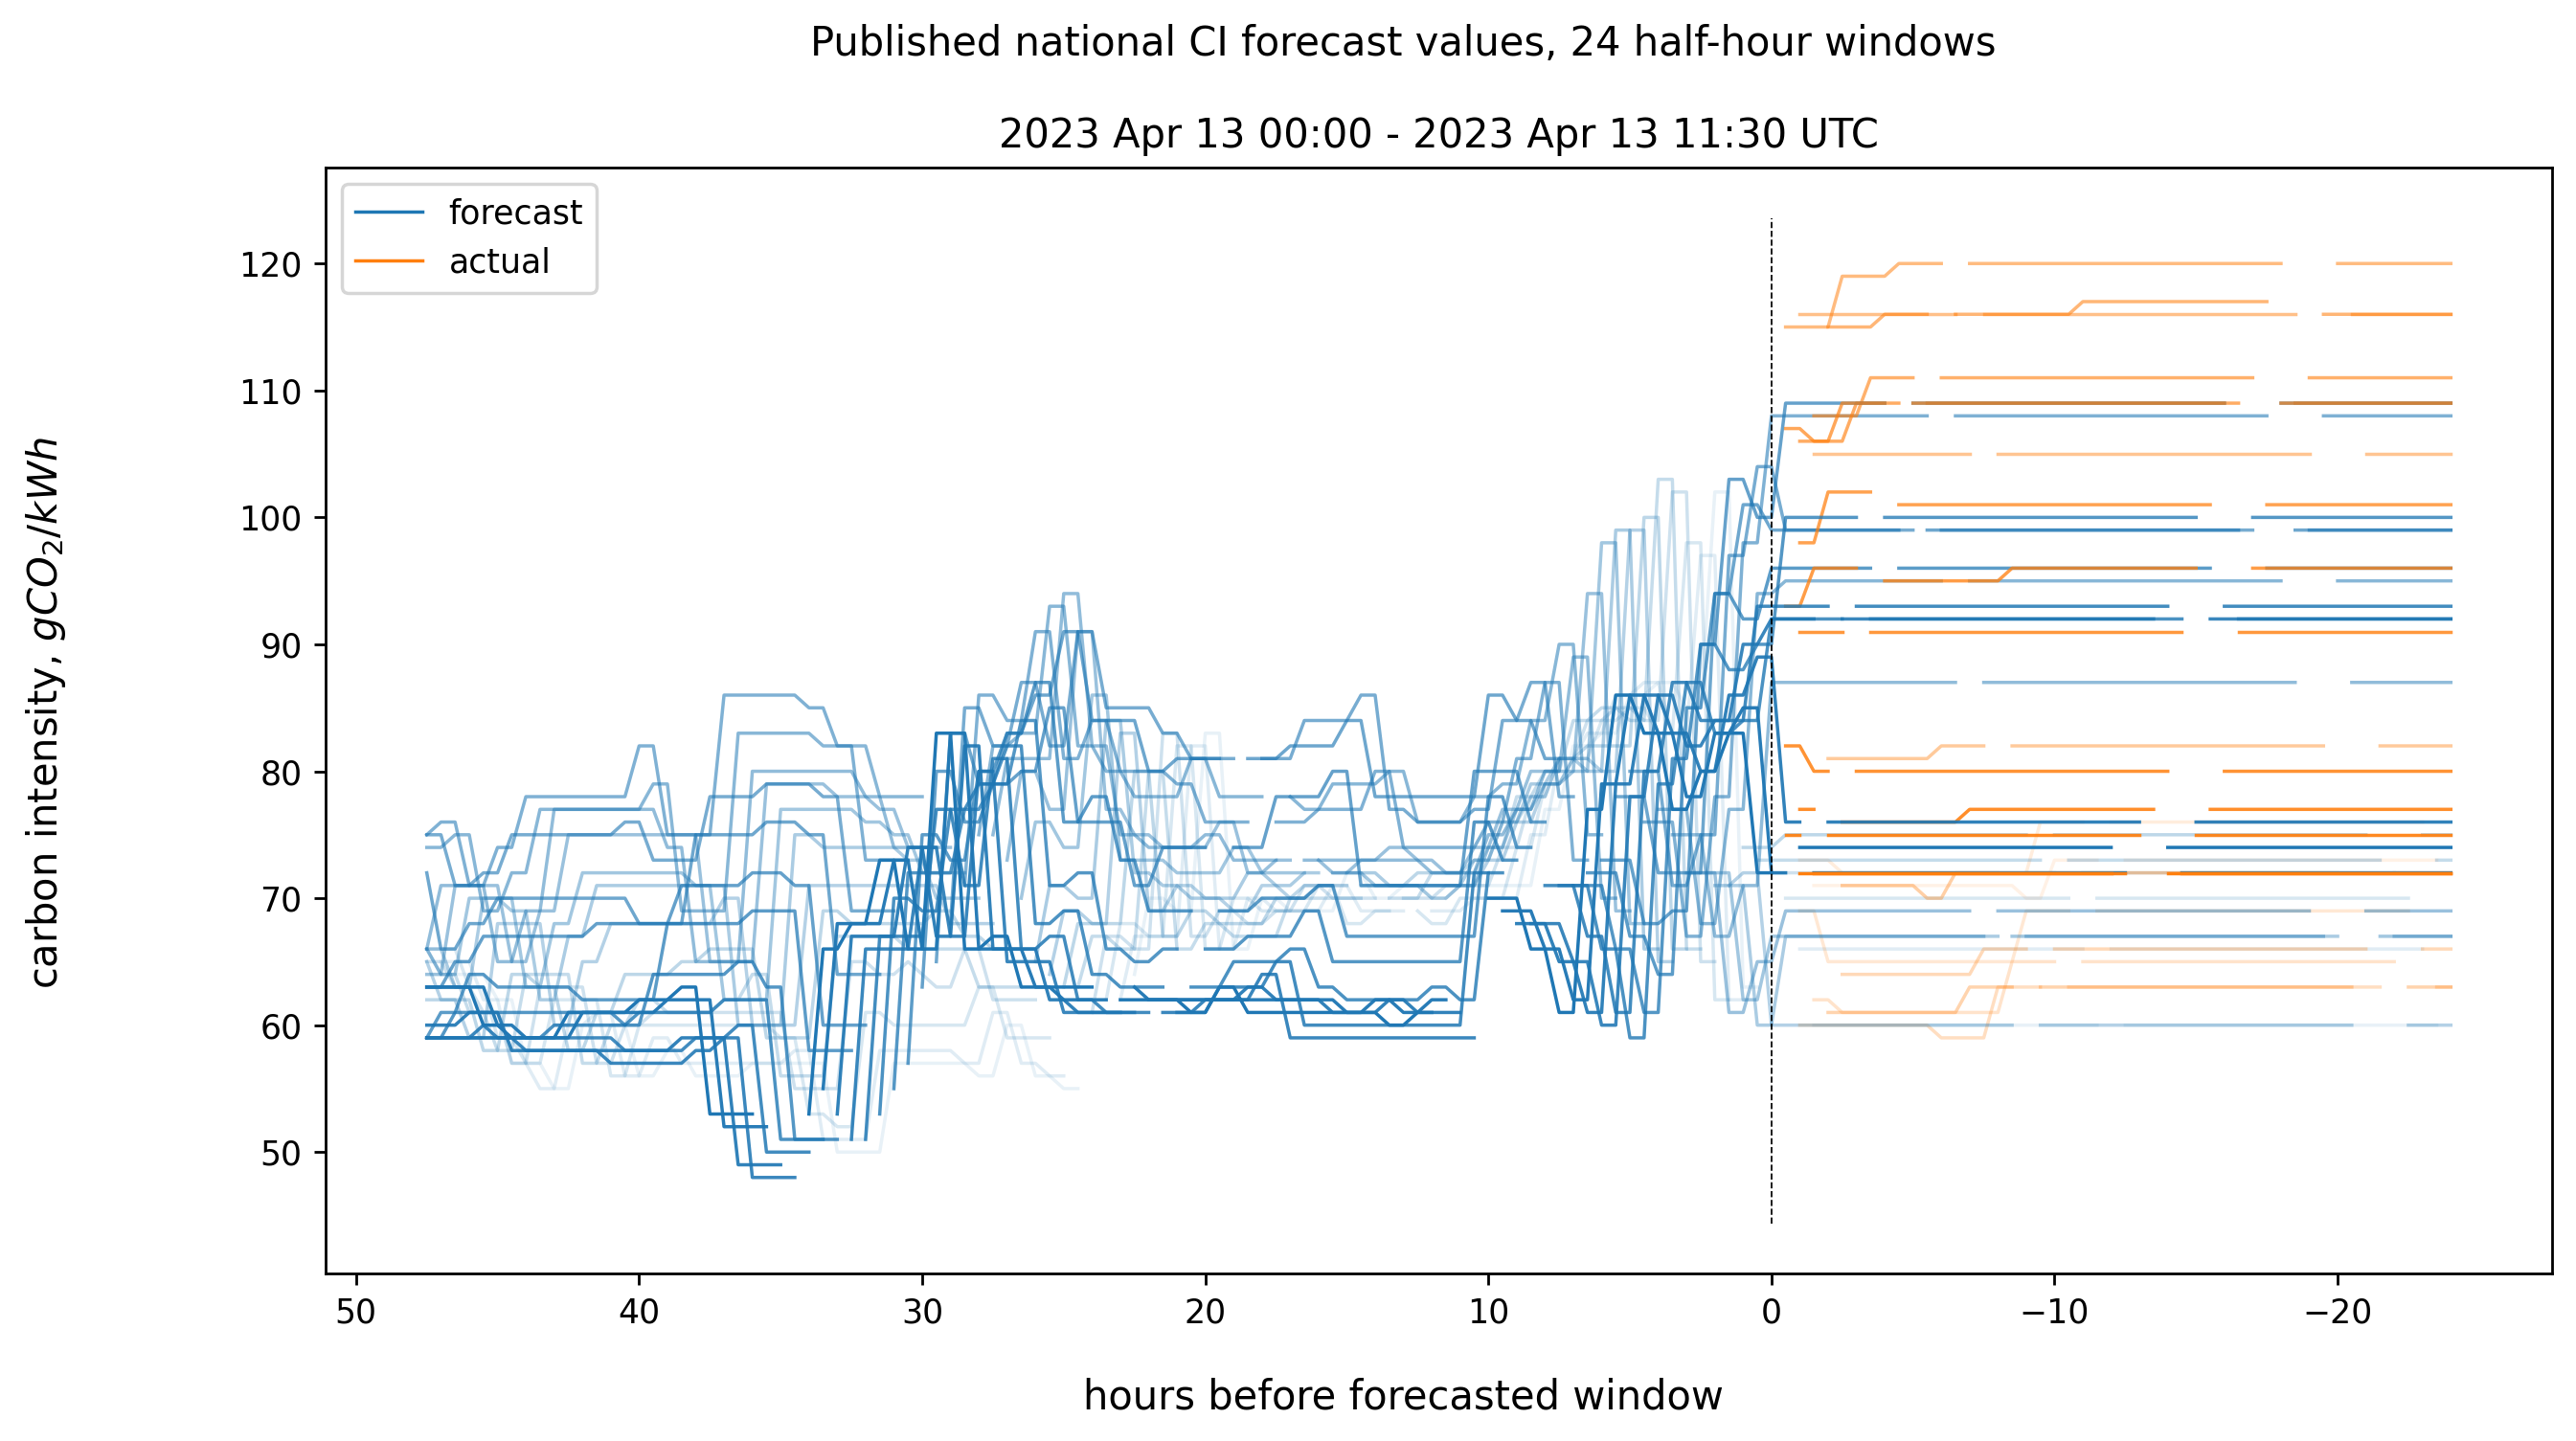

In [10]:
fig = generate_plot_ci_lines(df, dates=dates[:24])

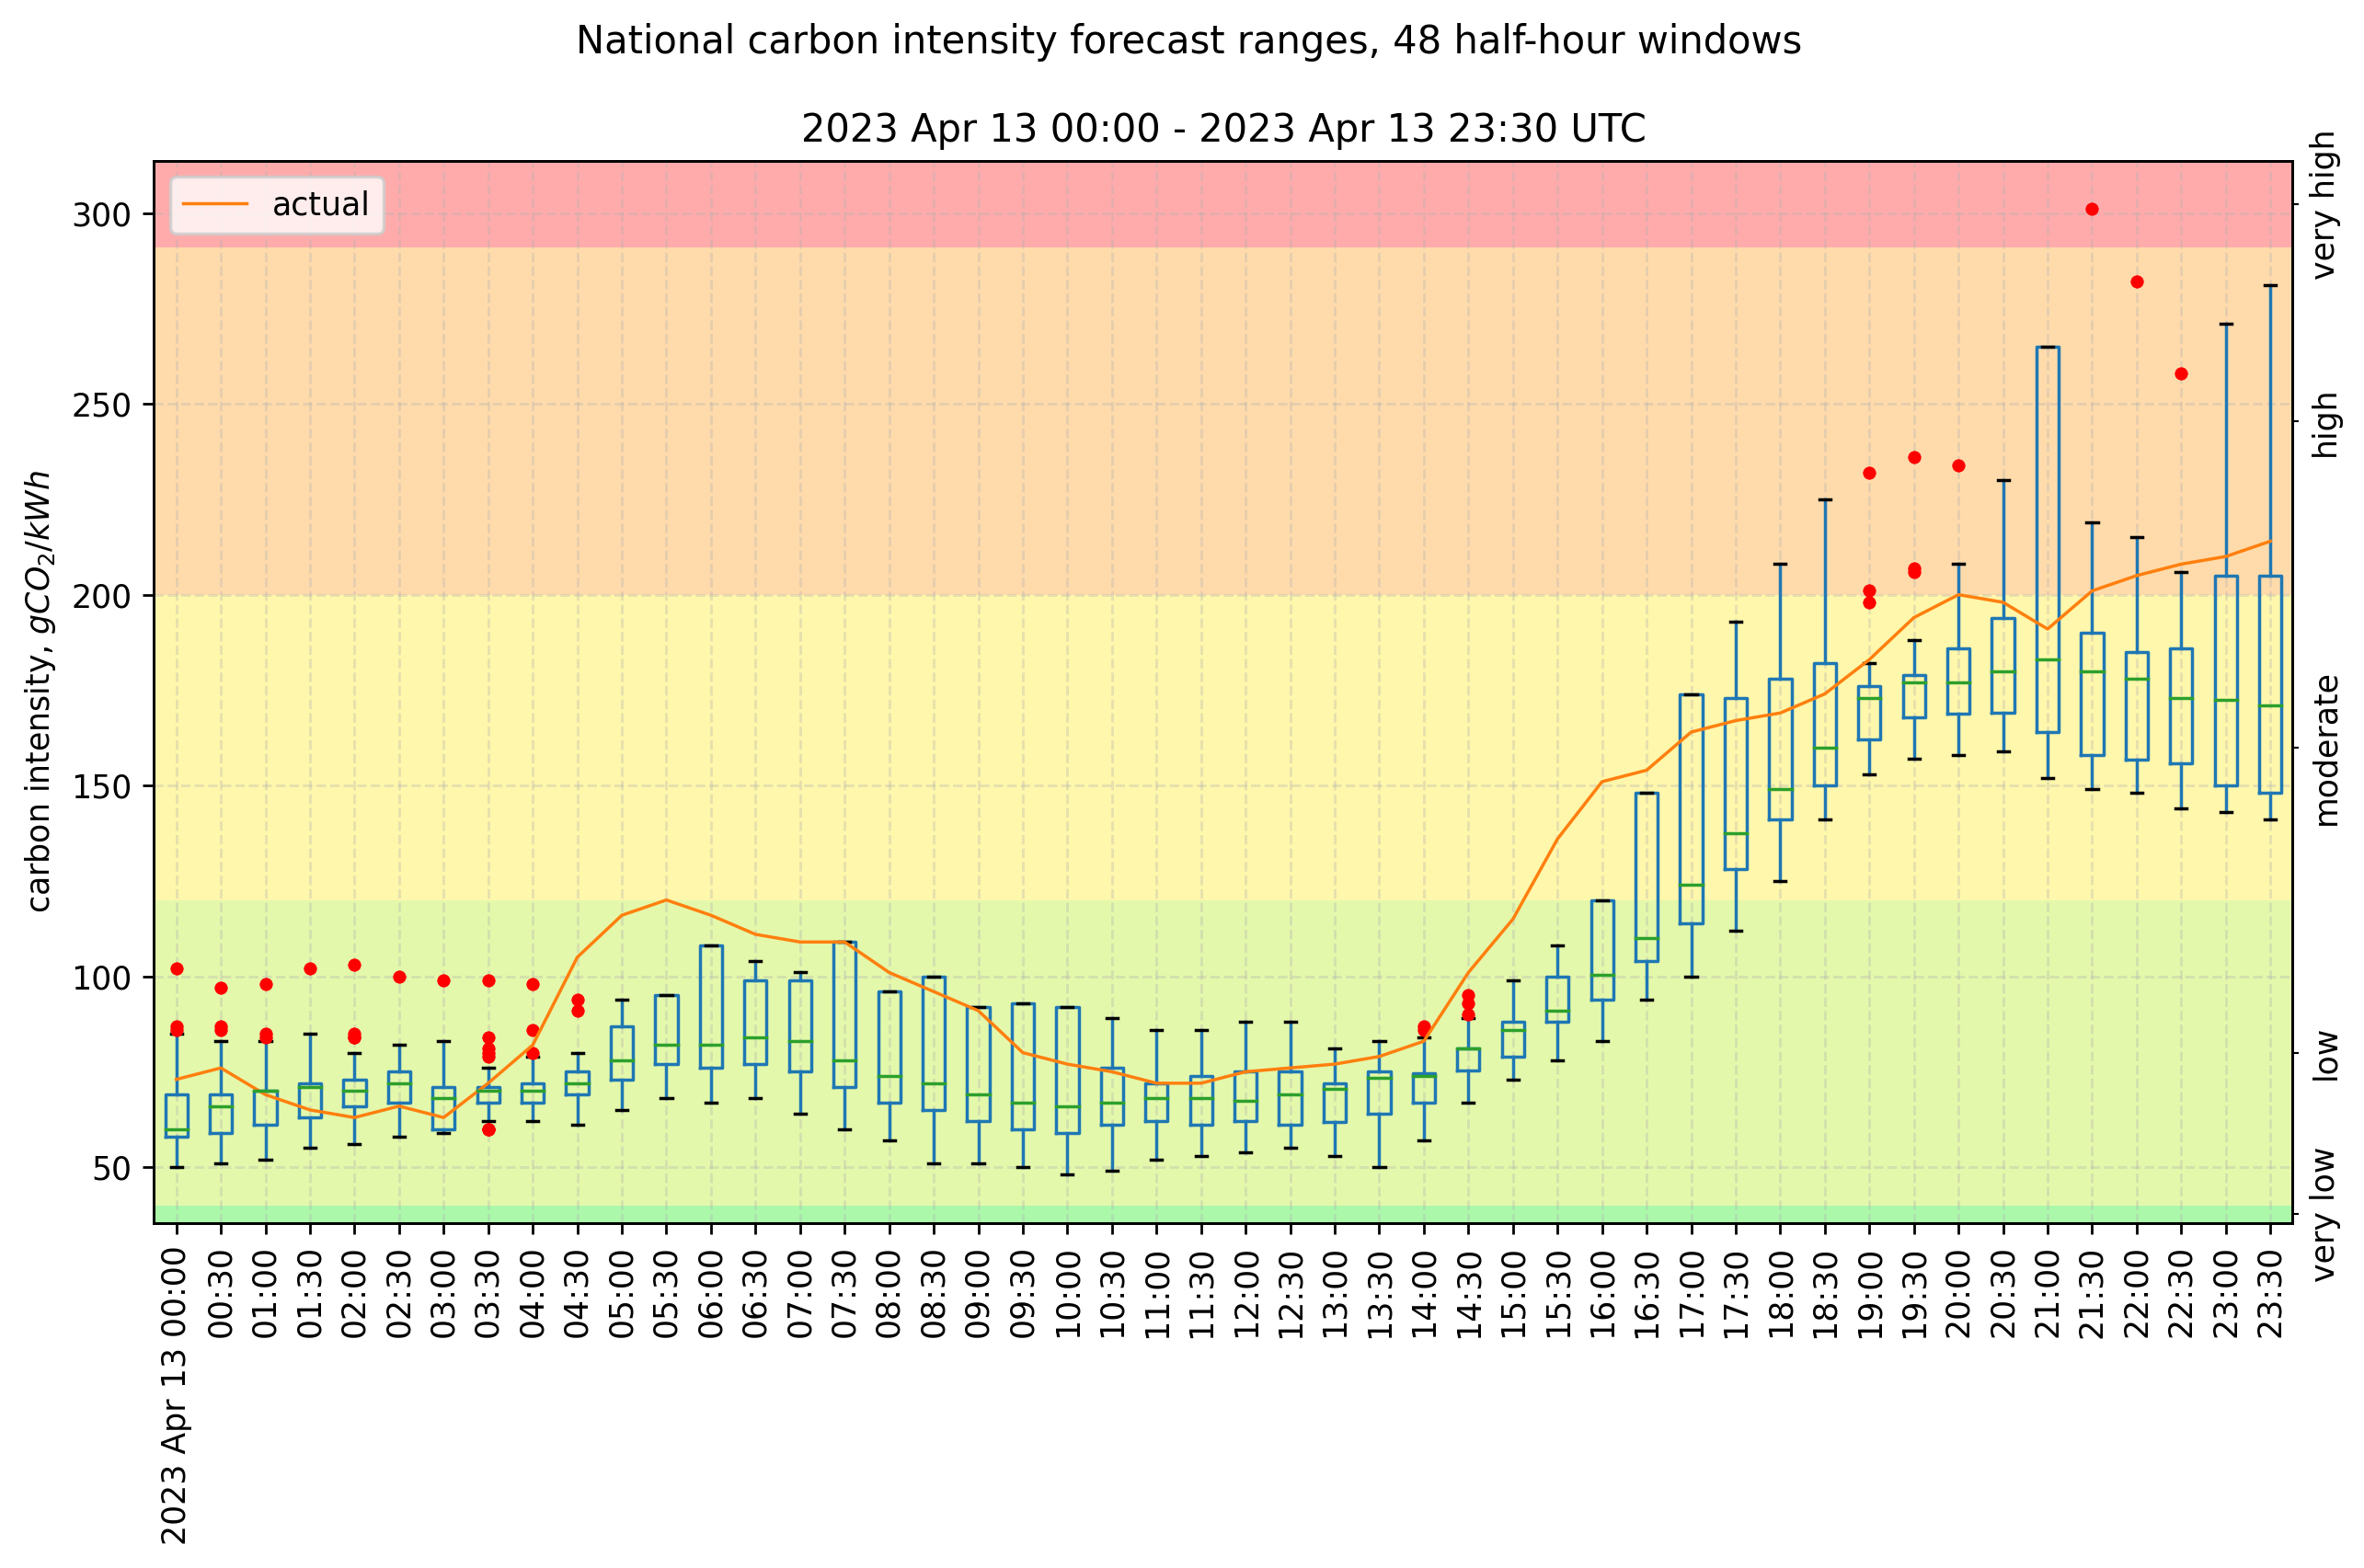

In [12]:
# Used in blog post

fig = generate_boxplot_ci(df, dates, colourmap=True)
save_figure(fig, "./charts", "ci_national_forecast_boxplots.png")

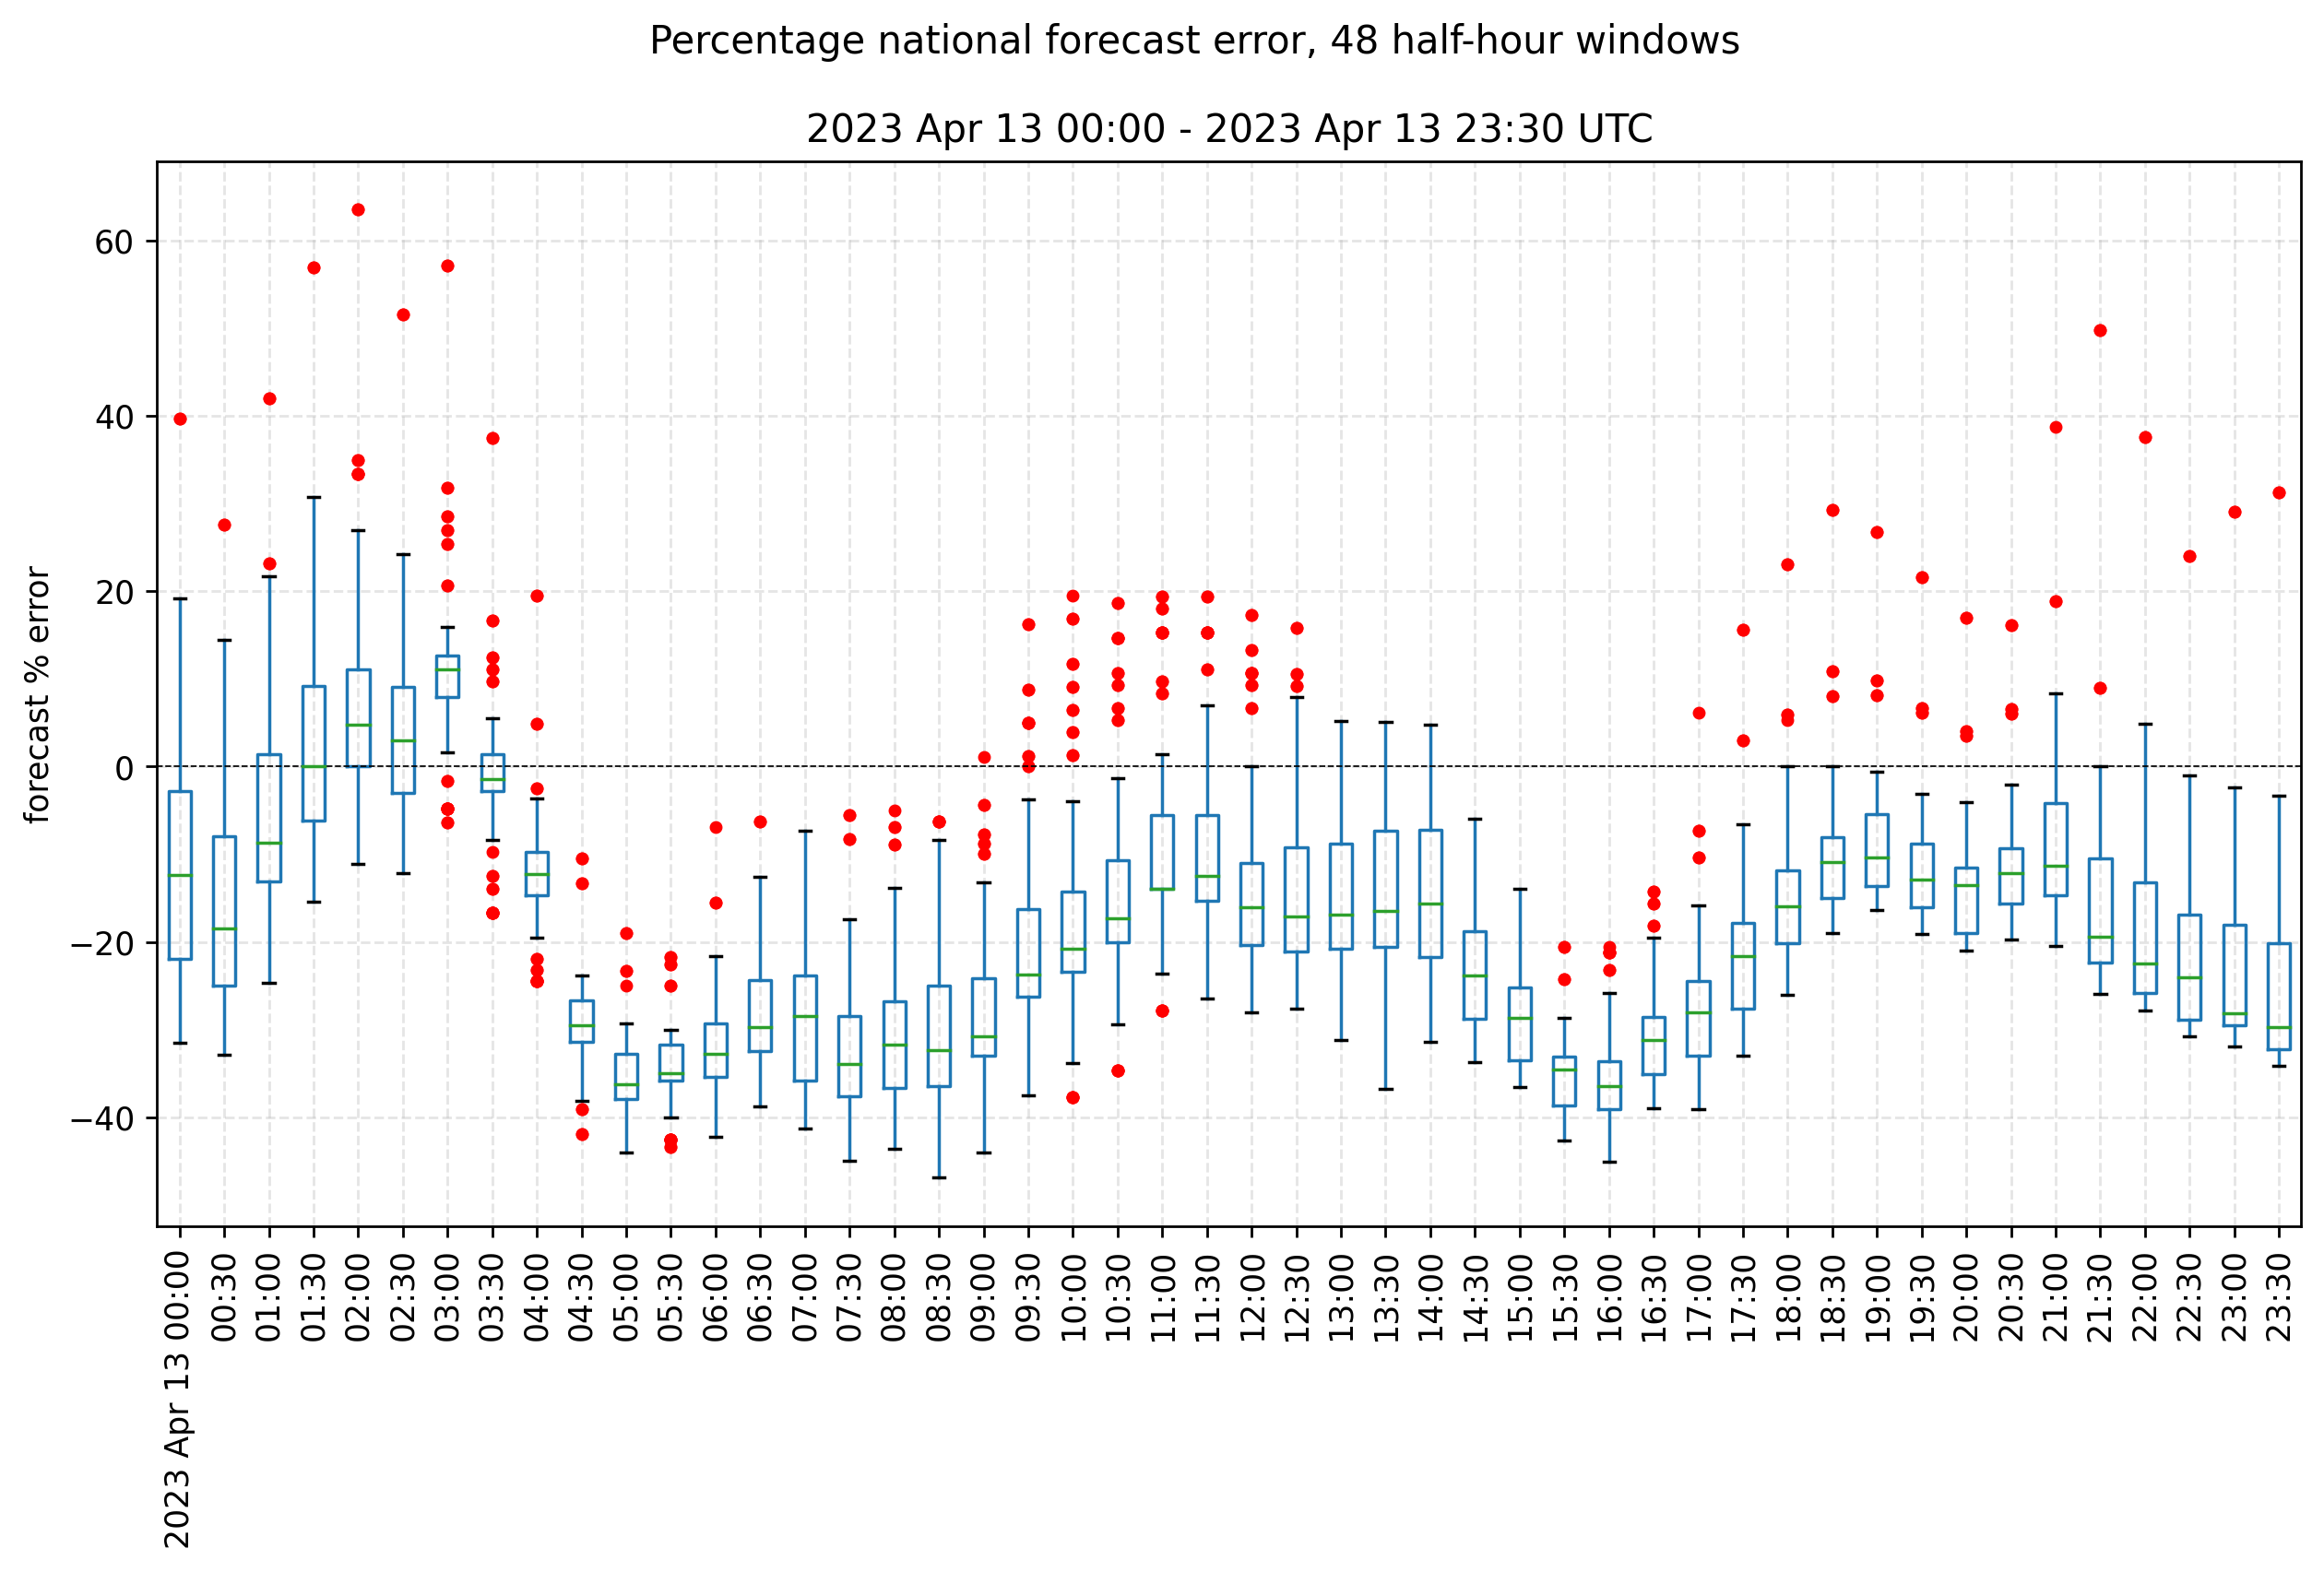

In [6]:
# Used in blog post

fig = generate_boxplot_ci_error(df, dates=dates)
save_figure(fig, "./charts", "ci_national_forecast_error_boxplots.png")

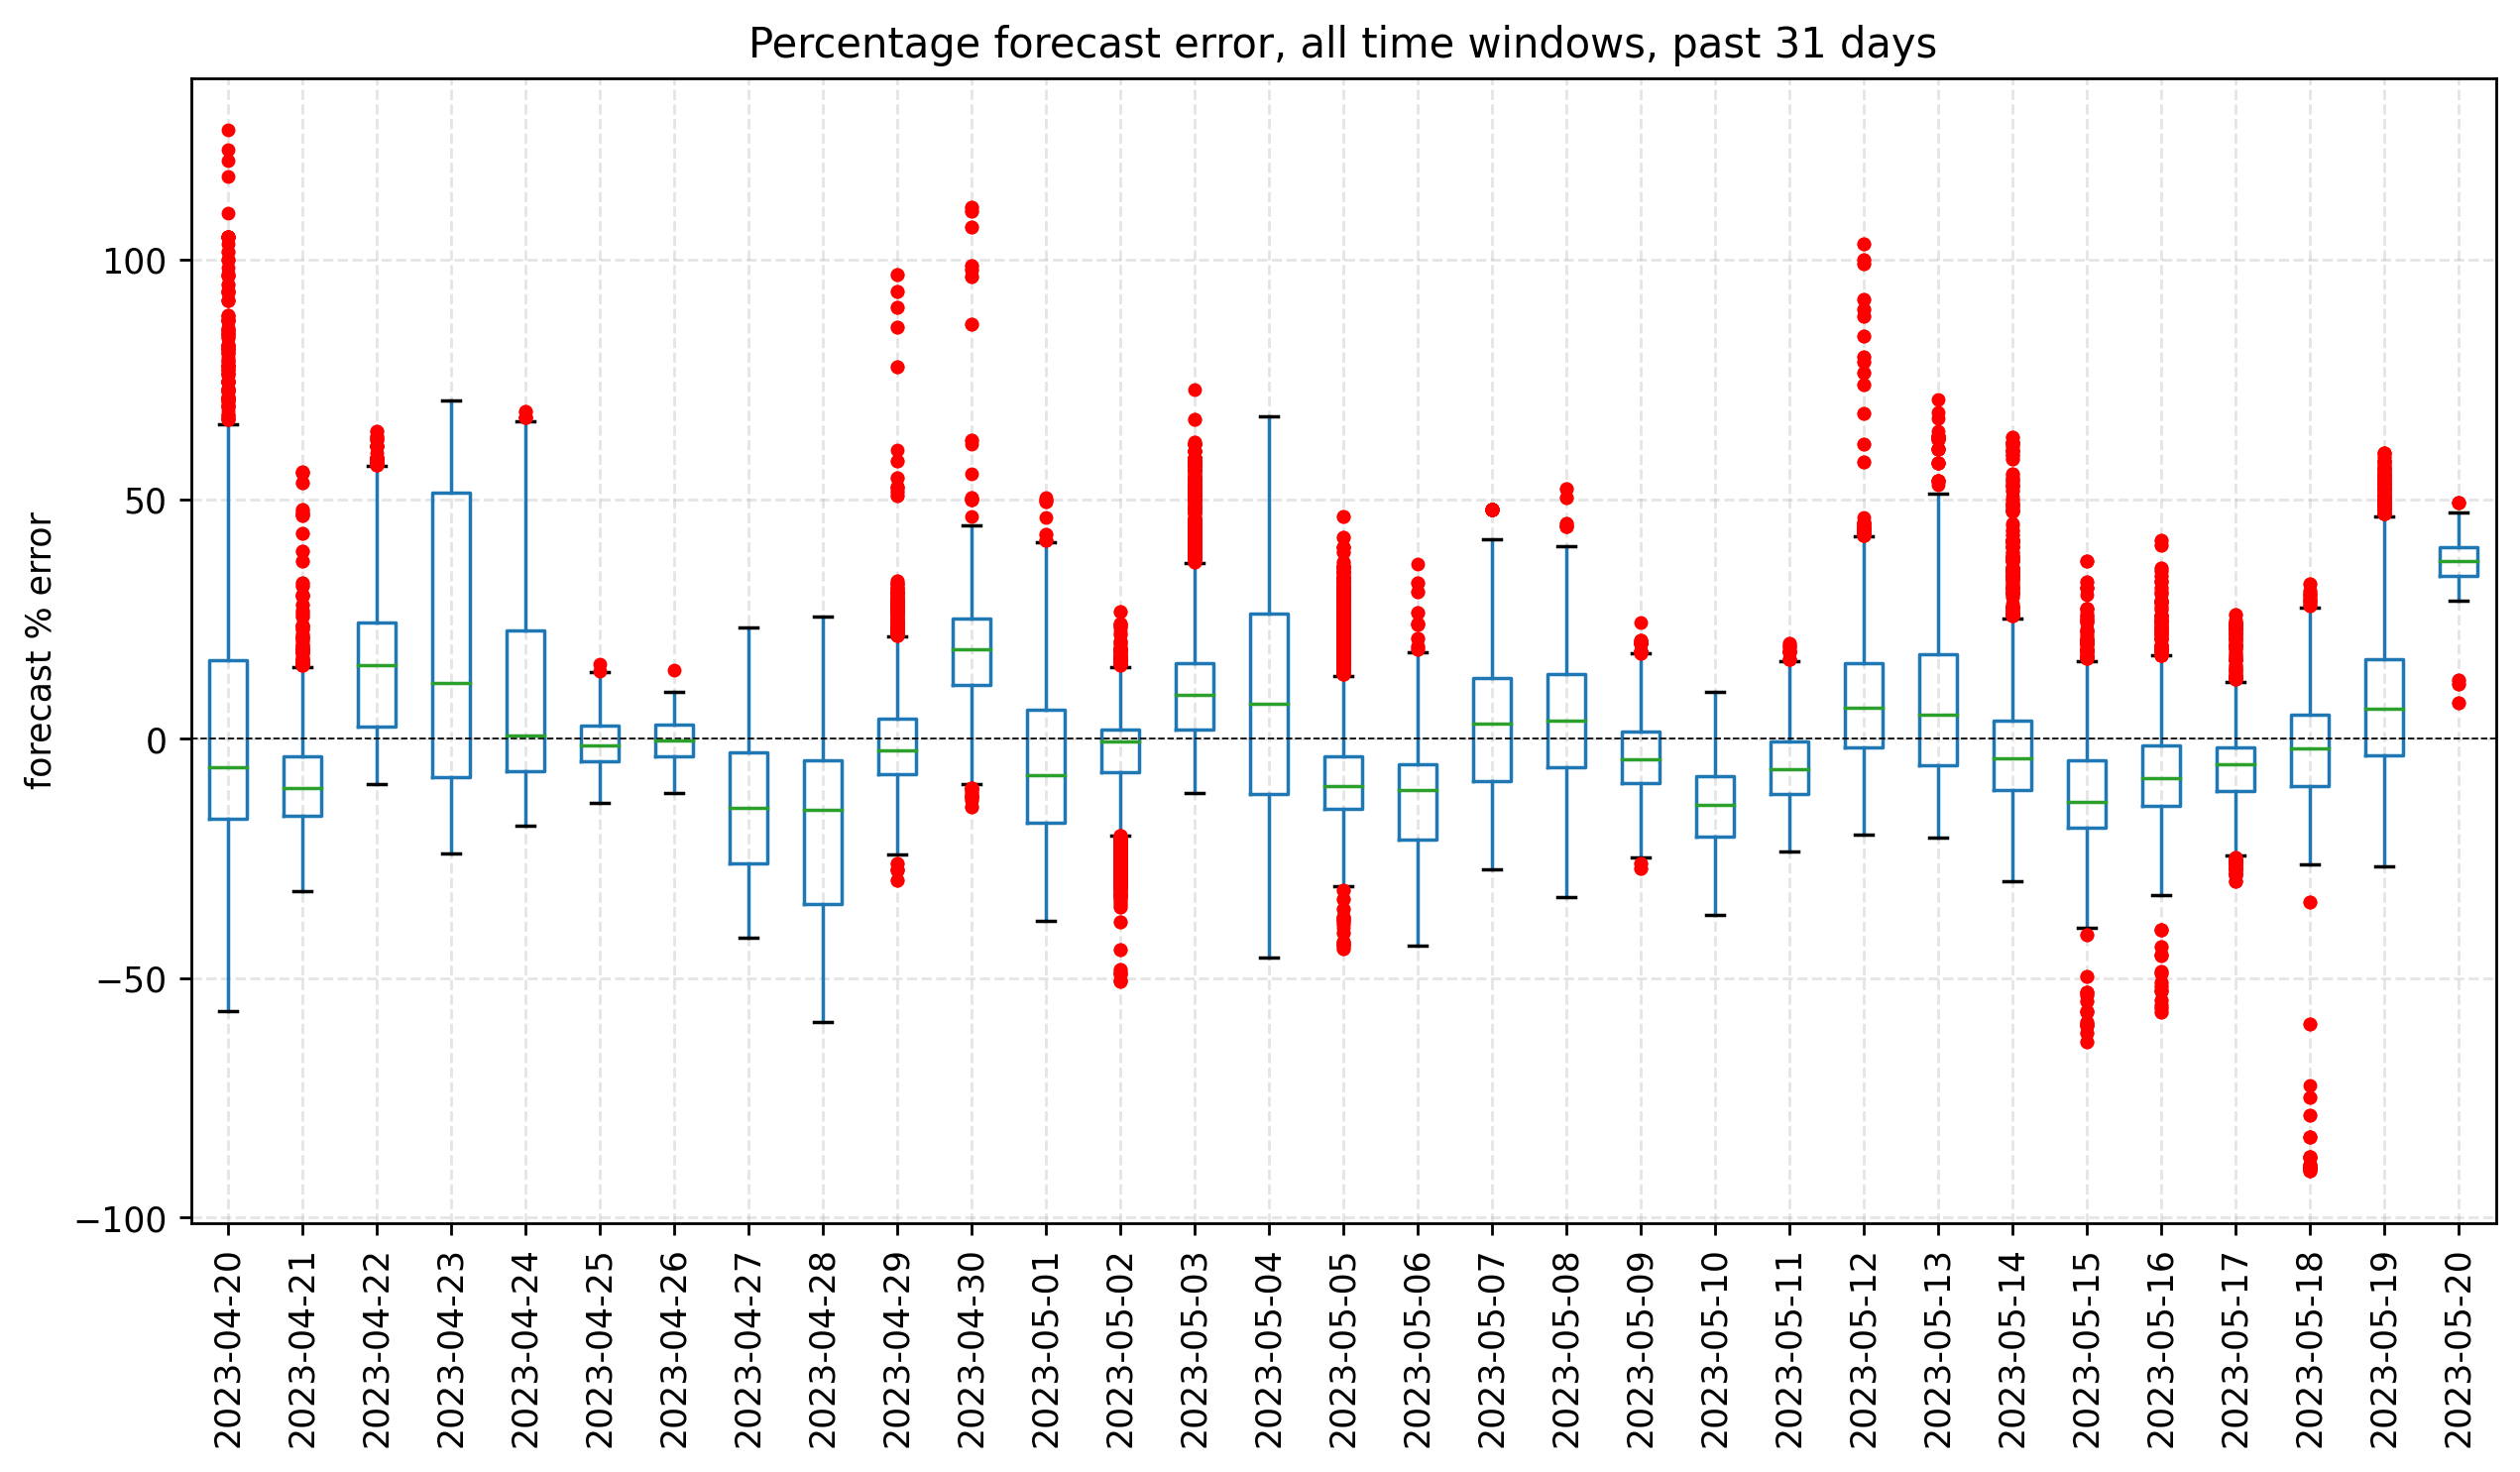

In [9]:
fig = generate_boxplot_ci_error_for_days(summaries_merged_df, days=30)
# save_figure(fig, ".", "ci_national_forecast_error_daily_boxplots.png")

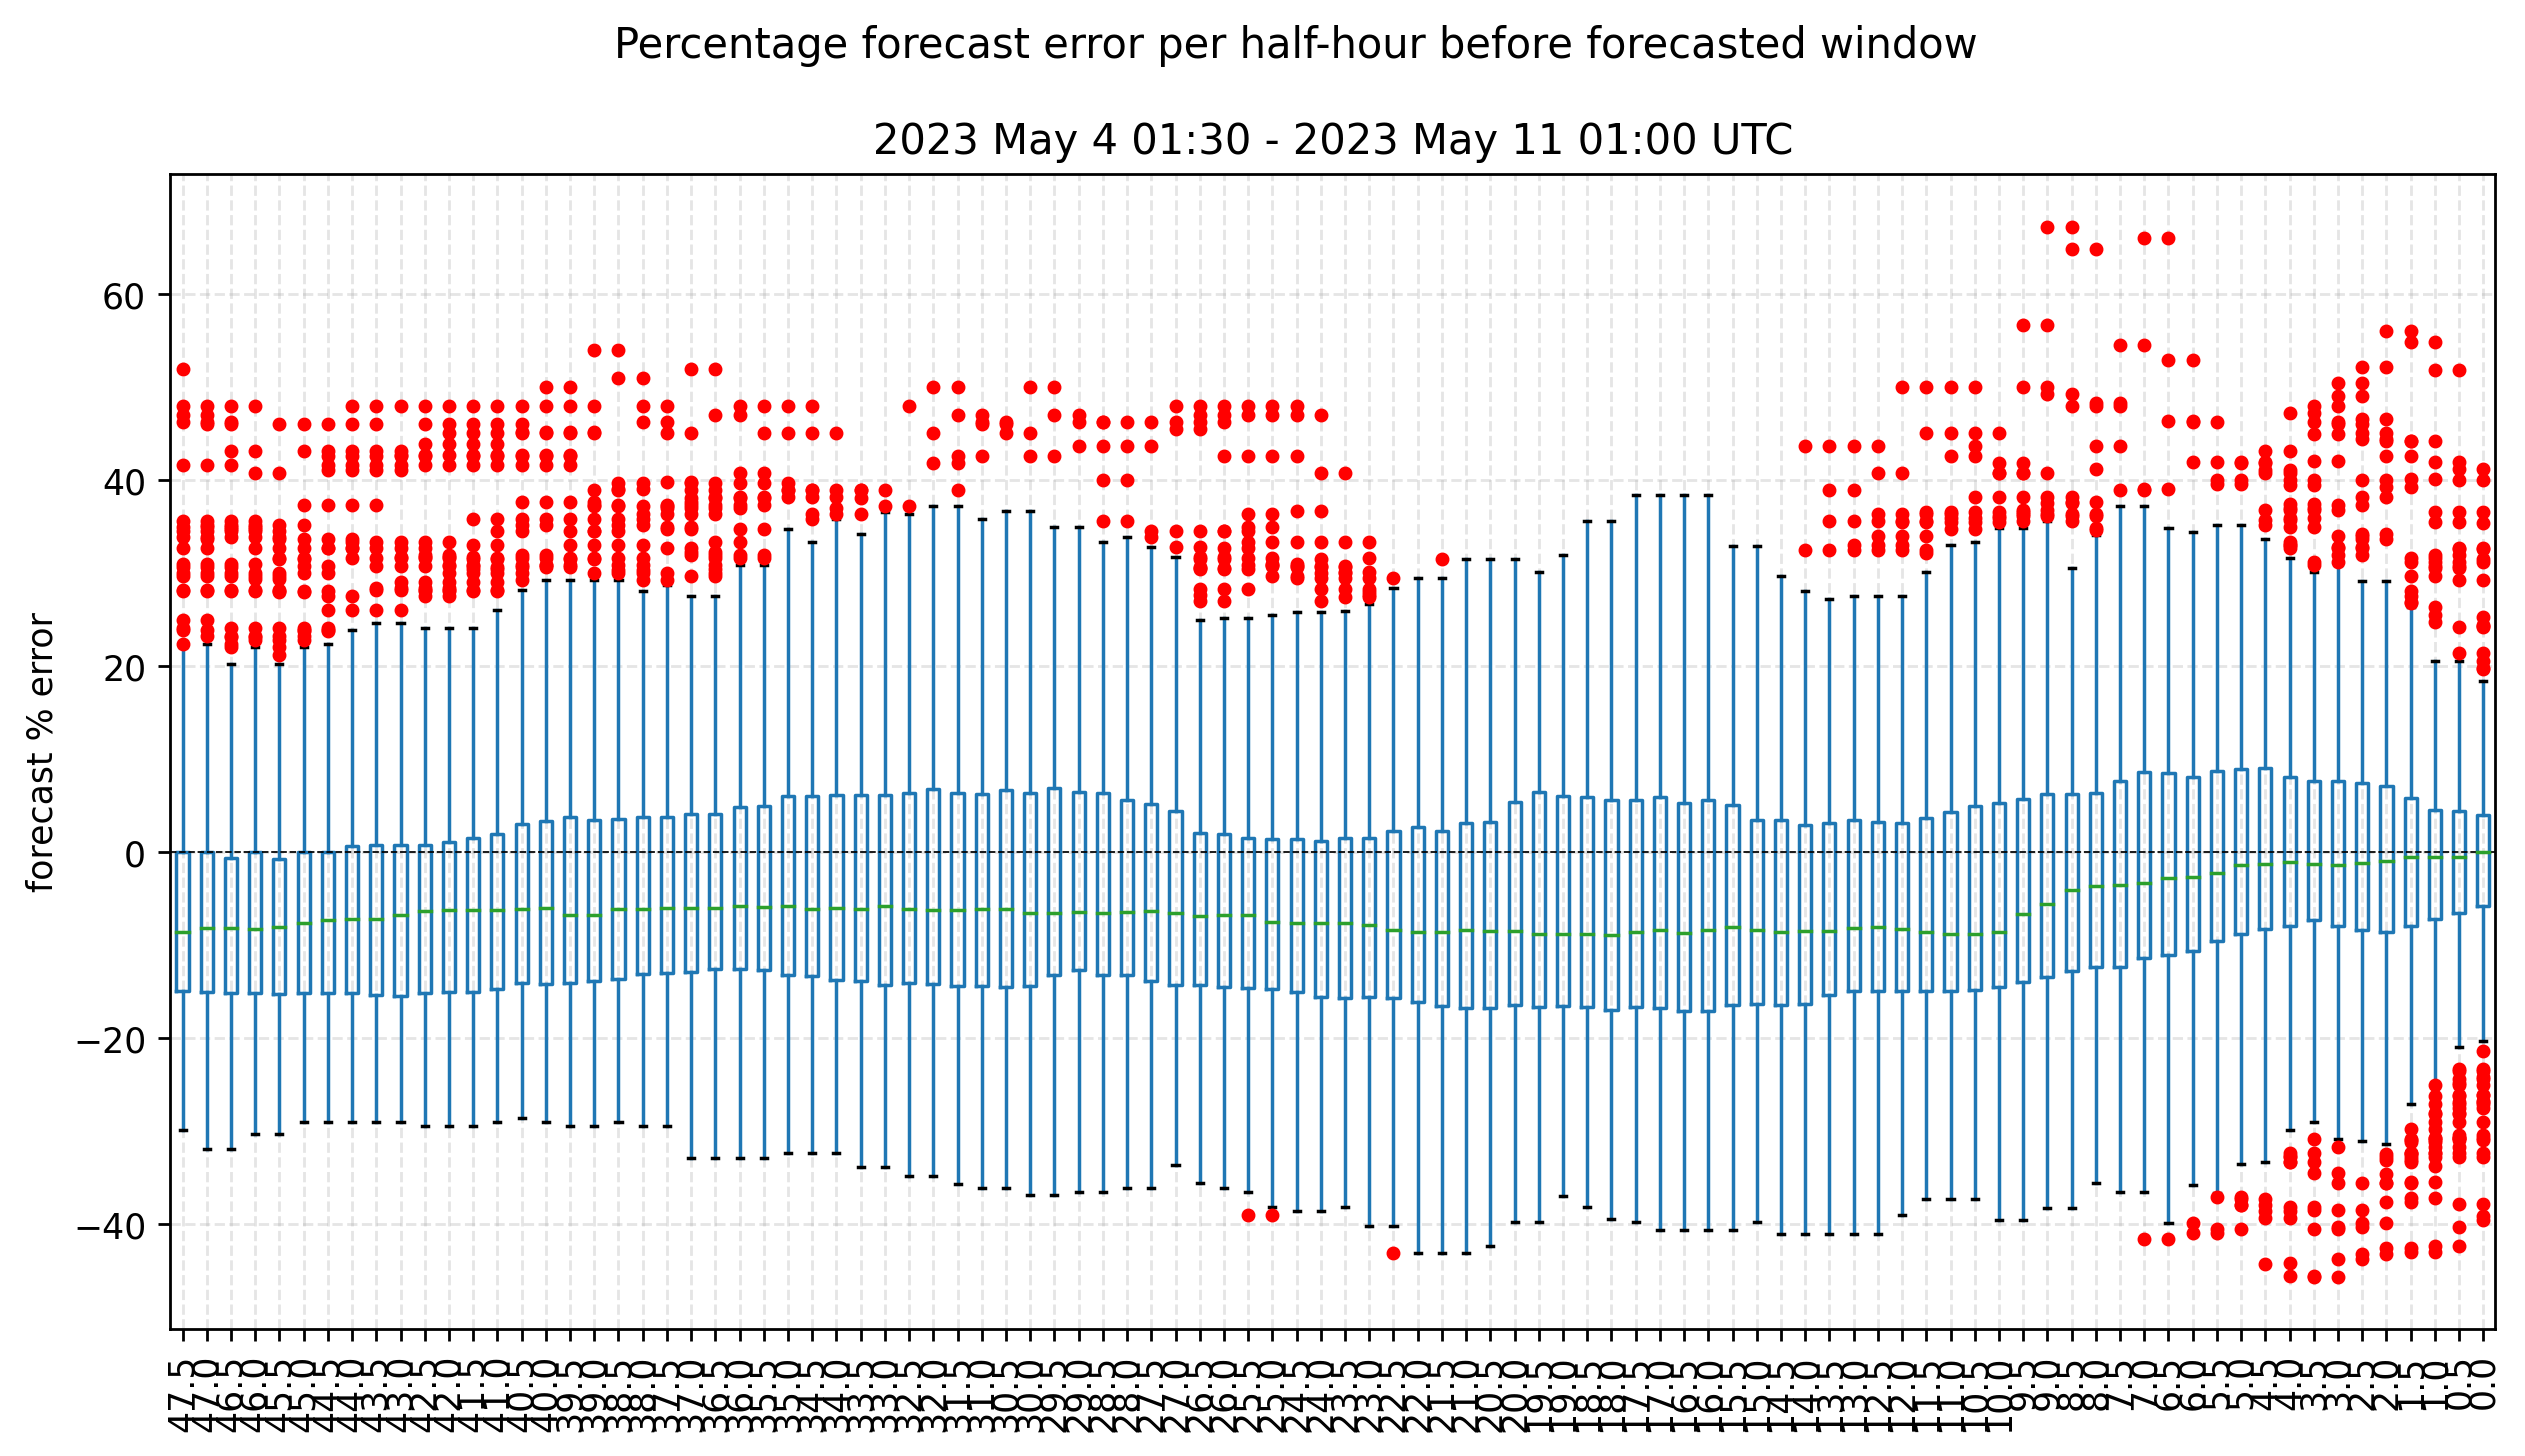

In [10]:
fig = generate_boxplot_ci_error_per_hour(summaries_merged_df, days=7)

Note these CIs assume an approximate Normal distribution, which we can see from the days' histograms is not true.

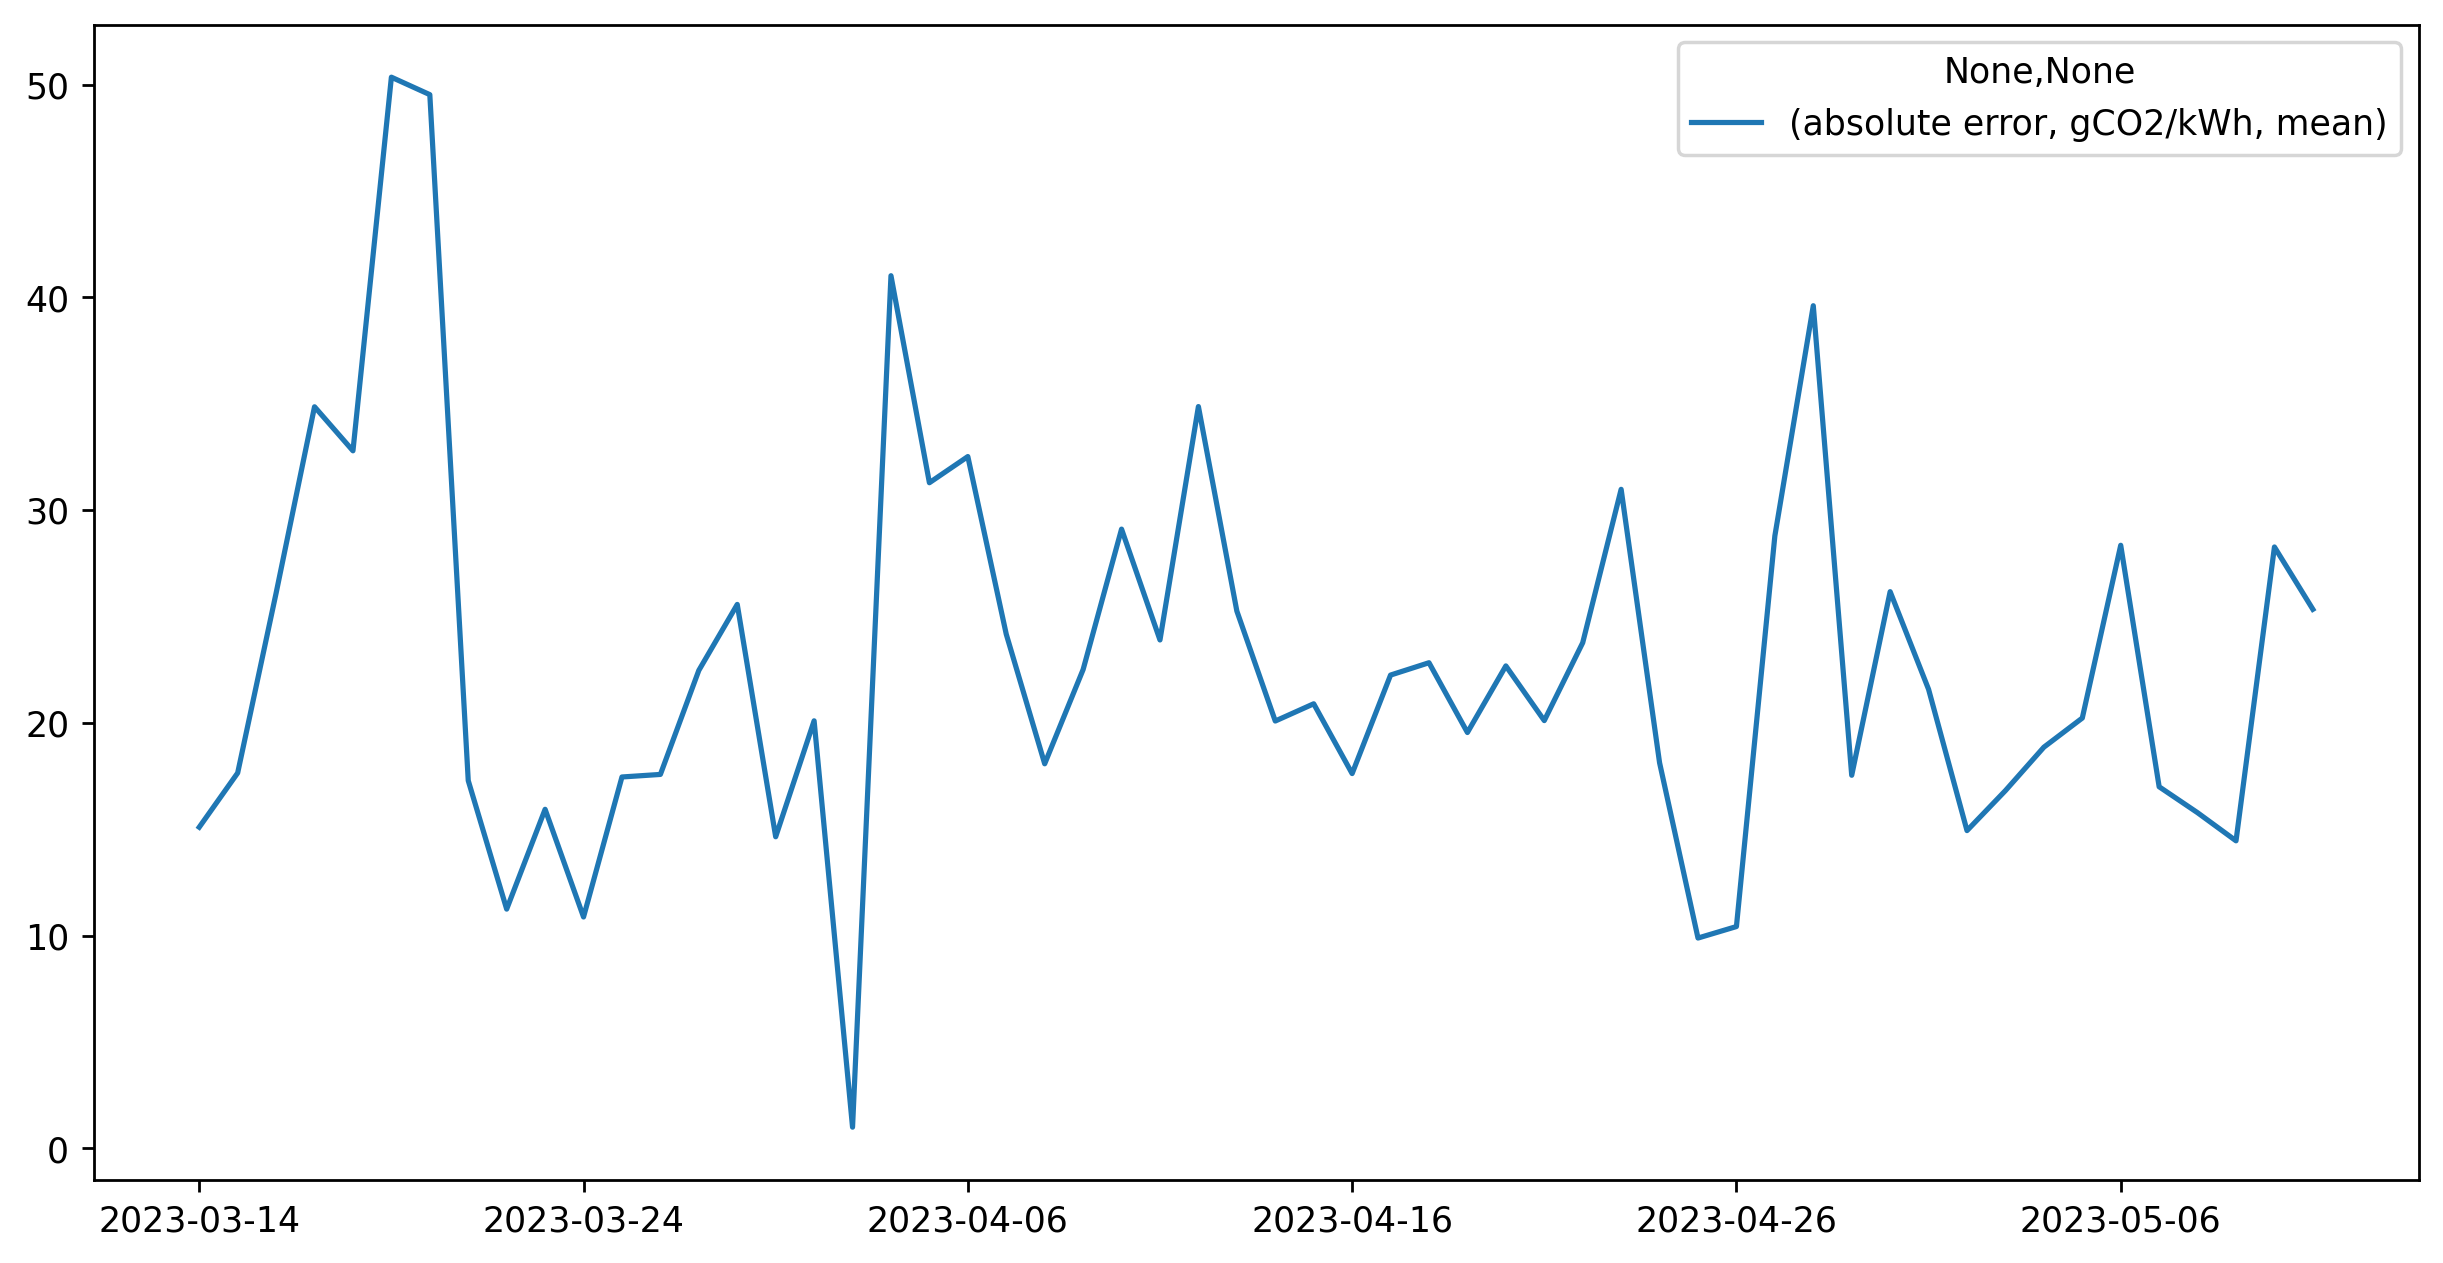

In [11]:
stats_combined_df = generate_combined_stats_dataframe(
    summaries_merged_df, days=365
)
ax = stats_combined_df.loc[:, pd.IndexSlice["absolute error, gCO2/kWh", ["mean"]]].astype("float").plot(use_index=True)

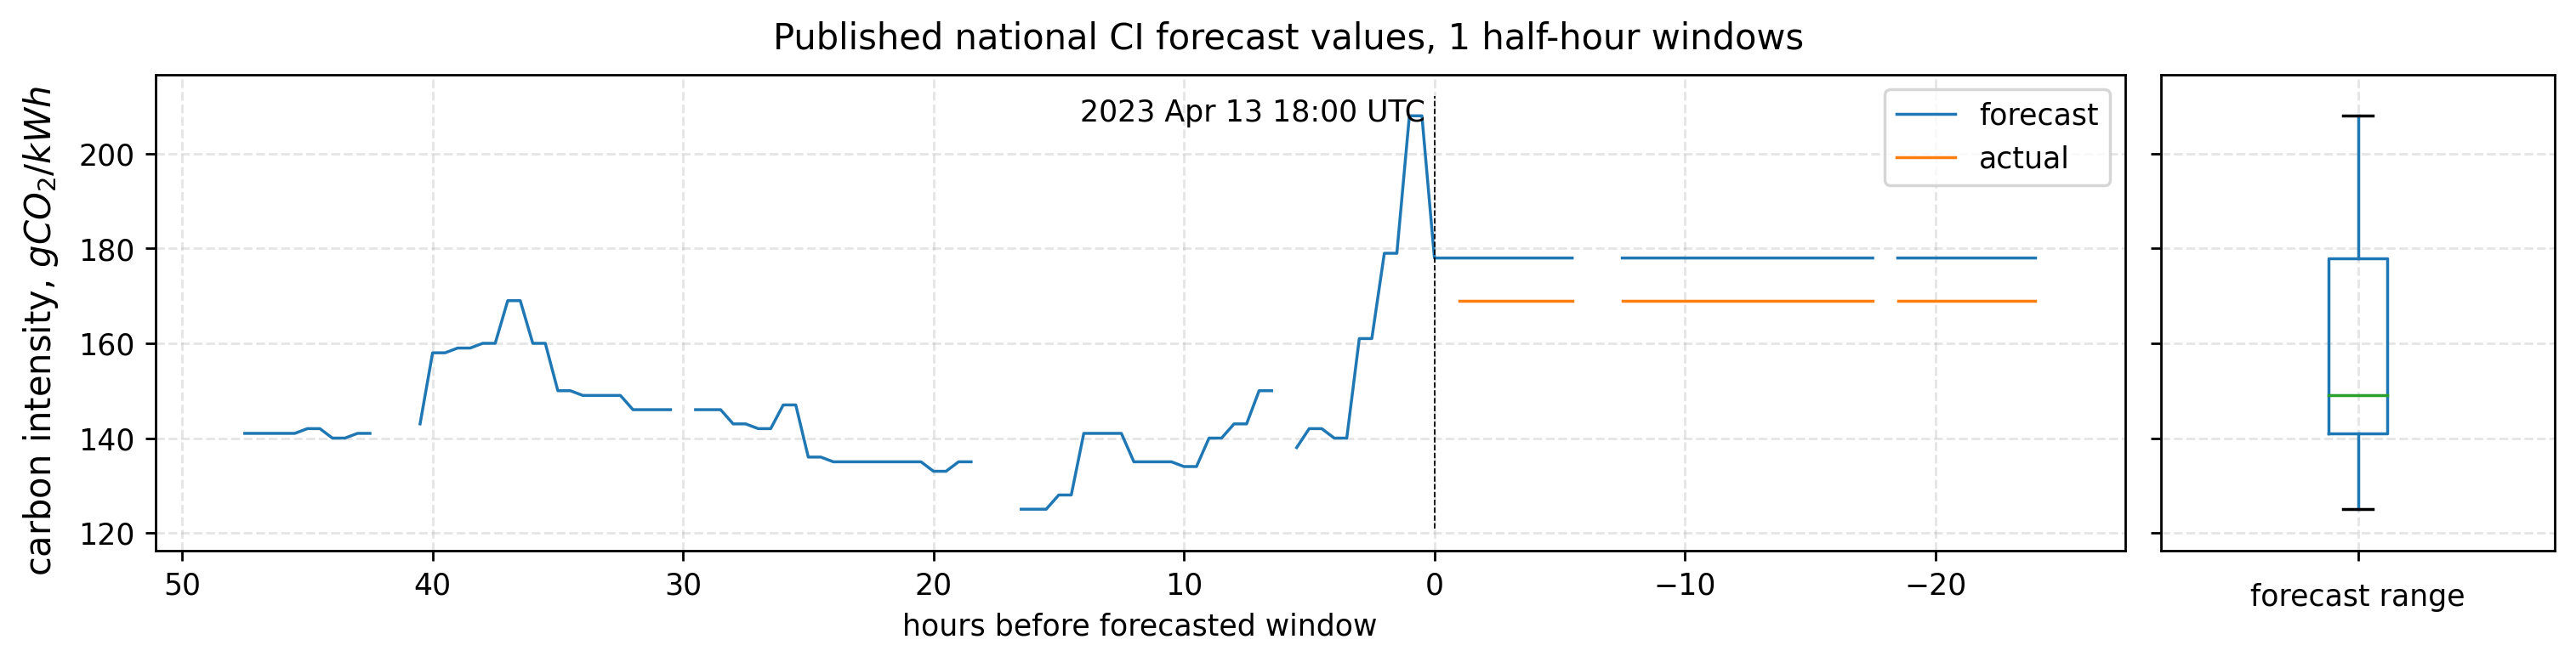

In [12]:
# Used in blog post
dt = datetime(2023,4,13,19,0).astimezone(timezone.utc)
dates = get_dates(df, start_date=dt, num_timepoints=1)
fig = generate_plots_ci_lines_with_boxplots(df, dates=dates)
# save_figure(fig, "./charts", "ci_national_forecast_trend_with_boxplot.png")

In [ ]:
# Half-hourly plots of forecasts
# This will produce many plots!

for hour in range(24):
    dt = datetime(2023,4,13,hour,0).astimezone(timezone.utc)
    dates = get_dates(df, start_date=dt, num_timepoints=1)
    fig = generate_plots_ci_lines_with_boxplots(df, dates=dates)

In [ ]:
# Daily plots of forecast ranges
# This will produce many plots!

dt = datetime(2023,3,15,1,0).astimezone(timezone.utc)
for i in range(30):
    dates = get_dates(summaries_merged_df, num_hours=24, start_date=dt)
    df = summaries_merged_df.loc[dates].copy()
    fig = generate_boxplot_ci(df, dates, colourmap=True)
    dt = dt + timedelta(days=1)